In [31]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import torch
# from tqdm import tqdm
from torch_geometric.utils import to_networkx
import networkx as nx
from gnn import GNN
import matplotlib.pyplot as plt
import os
import numpy as np
from gnn import GNN
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.data import Data, Batch
import plotly.express as px
import matplotlib.colors as mcolors
import random
import pickle

if not os.path.isdir("figures"): os.mkdir("figures")

In [32]:
atom_indices = {
    0: "C",
    1: "N",
    2: "O",
    3: "F",
    4: "I",
    5: "Cl",
    6: "Br",
}

edge_indices = {
    0: "aromatic",
    1: "single",
    2: "double",
    3: "triple",
}

atom_colors = {
    0: "#9b5fe0",
    1: "#16a4d8",
    2: "#60dbe8",
    3: "#efdf48",
    4: "#f9a52c",
    5: "#d64e11",
    6: "#8bd346",
}

dataset = TUDataset(root='data/TUDataset', name='MUTAG')
loader = DataLoader(dataset, batch_size=64)
molecules = True
model_path = "models/MUTAG_model.pth"

In [33]:
with open("data/OurMotifs/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
molecules = False
model_path = "models/OurMotifs_model_mean.pth"

In [34]:
num_node_features = dataset[0].x.shape[1]
node_colors = {i:c for i,c in enumerate(random.choices(list(mcolors.CSS4_COLORS.values()), k=num_node_features))}
node_colors

{0: '#D3D3D3', 1: '#008000', 2: '#808000', 3: '#008000', 4: '#FFC0CB'}

In [35]:
nn = torch.load(model_path)
nn.eval()

GNN(
  (layers): ModuleDict(
    (Conv_0): SAGEConv(5, 4, aggr=mean)
    (Conv_0_Relu): ReLU()
    (Conv_1): SAGEConv(4, 4, aggr=mean)
    (Conv_1_Relu): ReLU()
    (Aggregation): SumAggregation()
    (Lin_0): Linear(in_features=4, out_features=4, bias=True)
    (Lin_0_Relu): ReLU()
    (Lin_Output): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [36]:
# nn.float()
nn.double()
all_outputs = []
max_output_value, min_output_value = None, None
max_activation_value = -float("inf")
for i, data in enumerate(dataset):
    data.x = data.x.double()
    outputs = nn(data).detach().numpy()
    if outputs[0][0] < -15: print(i)
    all_outputs.append(outputs)
    if max_output_value is None: max_output_value, min_output_value = -float("inf")*np.ones_like(outputs), float("inf")*np.ones_like(outputs)
    max_output_value = np.max(np.stack([max_output_value, outputs]),axis=0)
    min_output_value = np.min(np.stack([min_output_value, outputs]),axis=0)

    all_activations = [output for _, output in nn.get_all_layer_outputs(data)]
    max_activation_value = max(max_activation_value, max(float(torch.max(torch.abs(activation))) for activation in all_activations))
print("Max Absolute Activation Value:", max_activation_value)
print("Max Class Output Value:", max_output_value)
print("Min Class Output Value:", min_output_value)
    


all_outputs = np.concatenate(all_outputs, axis=0)
for i in range(all_outputs.shape[-1]):
    px.histogram(all_outputs[:, i], title=f"Class {i} Logit Distribution", color=[d.y for d in dataset], color_discrete_map={0: "Red", 1: "Blue"}).show()

Max Absolute Activation Value: 18.60566749488361
Max Class Output Value: [[14.81253542  2.77243638]]
Min Class Output Value: [[ -3.17805719 -18.60566749]]


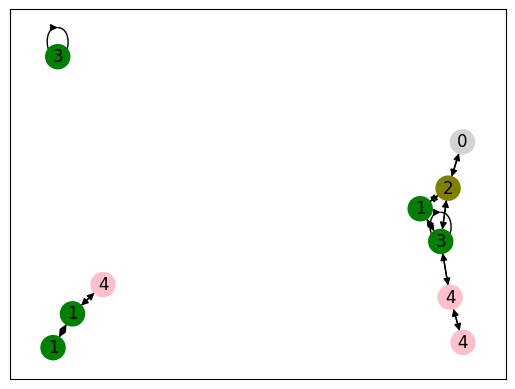

In [37]:
index = "Final"
A = np.load(f"./solutions/A_{index}.npy")
X = np.load(f"./solutions/X_{index}.npy")

G = nx.from_numpy_array(A, create_using=nx.DiGraph)

labels = dict(zip(range(X.shape[0]), map(atom_indices.get, np.argmax(X, axis=1)))) if molecules else dict(zip(range(X.shape[0]), np.argmax(X, axis=1)))
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=7)
x_indices = np.argmax(X, axis=1)
node_color = list(map((atom_colors if molecules else node_colors).get, x_indices))
nx.draw_networkx(G, pos=pos, with_labels=True, labels=labels, node_color=node_color)


In [38]:
plt.close()

In [39]:
folder = "figures"
for i in range(19):
    A = np.load(f"./solutions/A_{i}.npy")
    X = np.load(f"./solutions/X_{i}.npy")
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    labels = dict(zip(range(X.shape[0]), map(atom_indices.get, np.argmax(X, axis=1)))) if molecules else dict(zip(range(X.shape[0]), np.argmax(X, axis=1)))
    fig, ax = plt.subplots()
    # pos = nx.circular_layout(G)
    pos = nx.spring_layout(G, seed=7)
    x_indices = np.argmax(X, axis=1)
    node_color = list(map((atom_colors if molecules else node_colors).get, x_indices))
    nx.draw_networkx(G, pos=pos, with_labels=True, labels=labels, node_color=node_color)

    
    plt.savefig(folder + "/file%02d.png" % i)
    plt.close()

# def generate_video(img):
#     for i in range(len(img)):
#         plt.imshow(img[i], cmap=cm.Greys_r)
#         plt.savefig(folder + "/file%02d.png" % i)

import subprocess
import glob
os.chdir(folder)
subprocess.call([
    'ffmpeg', '-framerate', '4', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', '-y',
    'graph_steps.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)
os.chdir("..")

ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvo

In [40]:
def to_batch(X, A):
    g = dict()
    g["edge_index"], g["edge_weight"] = dense_to_sparse(A)
    g["x"] = X
    return Batch.from_data_list([Data(**g)])

In [41]:
nn.double()

GNN(
  (layers): ModuleDict(
    (Conv_0): SAGEConv(5, 4, aggr=mean)
    (Conv_0_Relu): ReLU()
    (Conv_1): SAGEConv(4, 4, aggr=mean)
    (Conv_1_Relu): ReLU()
    (Aggregation): SumAggregation()
    (Lin_0): Linear(in_features=4, out_features=4, bias=True)
    (Lin_0_Relu): ReLU()
    (Lin_Output): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [42]:
# batch = to_batch(torch.Tensor(X).double(), torch.Tensor(A.astype(int)))
# print("NN output given X", nn.get_embedding_outputs(batch)[1].detach().numpy())
print("NN output given X", nn.forwardXA(X, A).detach().numpy())

NN output given X [[ 7.36038406 -9.8618743 ]]


In [43]:
dataset[0]

Data(x=[10, 5], edge_index=[2, 32], y=0, batch=[10], edge_weight=[32])

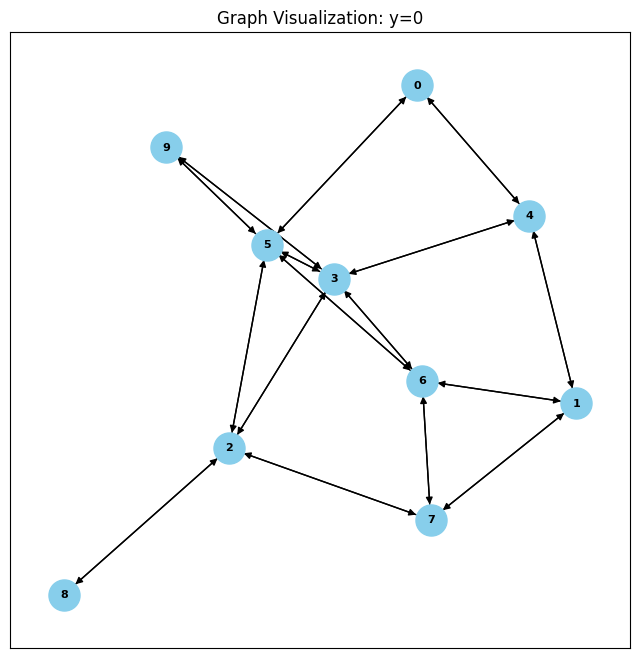

tensor([[ 6.6374, -8.9866]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

def visualize_graph(data):
    # Convert PyG Data object to networkx graph
    G = to_networkx(data)

    # Create a plot and customize its appearance
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=8, font_weight='bold', font_color='black')

    if data.edge_attr is not None:
        edge_labels = {(u, v): data.edge_attr[idx].item() for idx, (u, v) in enumerate(data.edge_index.T)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

    plt.title(f"Graph Visualization: y={data.y}")
    plt.show()
G = dataset[0]
G.x = G.x.double()
visualize_graph(G)
nn(G)

In [45]:
nn.get_all_layer_outputs(dataset[922])

[('Input',
  tensor([[0., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 0., 0., 1., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 1., 0.],
          [0., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1.]], dtype=torch.float64)),
 ('Conv_0',
  tensor([[ 0.9086, -0.4156,  0.4482,  0.5908],
          [ 0.6622, -0.2416, -0.4531,  0.7096],
          [ 0.8857, -0.3015,  0.4552,  0.5627],
          [ 0.9733, -0.0182,  0.9752,  0.3892],
          [ 0.7285,  0.8838,  0.4454,  0.4932],
          [ 0.4642,  0.8346,  0.5019, -0.0191],
          [ 1.0343, -0.3225,  0.9566,  0.4640],
          [ 0.9472, -0.0678,  0.3009,  0.7547],
          [ 0.7970, -0.0502, -0.7111,  1.0616],
          [ 0.8275,  1.3625,  0.5312,  0.4954]], dtype=torch.float64,
         grad_fn=<AddBackward0>)),
 ('Conv_0_Relu',
  tensor([[0.9086, 0.0000, 0.4482, 0.5908],
          [0.6622, 0.0000, 0.0000, 